На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 

Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

Задания:

1.Выберите метод, который предположительно подойдет в первом вопросе.

2.Проверьте, являются ли дисперсии внутри групп гомогенными.

3.Проведите тест на нормальность распределения.

4.Сравните средние в представленных группах.

5.Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия.

6.Примите решение: какие картинки в итоге будем использовать?

7.Выберите метод для второго теста.

8.Визуализируйте распределение events для контрольной и тестовой групп. 

9.Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя. 

10.Выберите формулу для модели, проведите тест.

In [36]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
sns.set(
    font_scale = 2, 
    style = "whitegrid", 
    rc = {'figure.figsize':(12,8)})

In [38]:
task_1 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-tulnikov-27/STATISTIKA/5_task_1.csv')

In [39]:
task_2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-m-tulnikov-27/STATISTIKA/5_task_2.csv')

In [40]:
task_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


id – id клиента в эксперименте

group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)

events – сколько блюд суммарно было заказано за период

Итак, первая задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. 

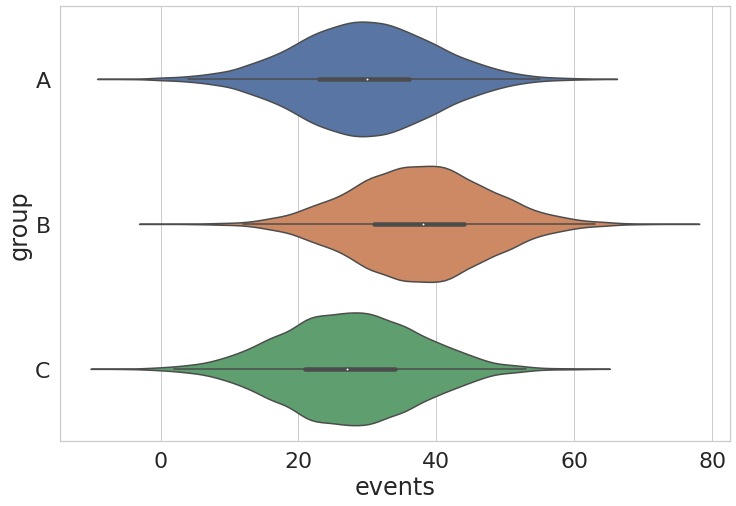

In [41]:
sns.violinplot(x="events", y="group", data=task_1)

In [42]:
pg.pairwise_gameshowell(data=task_1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,0.001,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,0.001,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.001,1.024138


Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными)

In [43]:
A = task_1.query('group == "A"').events
B = task_1.query('group == "B"').events
C = task_1.query('group == "C"').events

In [44]:
ss.levene(A, B, C)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

p-value > 0.05, не отклоняем нулевую гипотезу

Убедимся, что данные распределены нормально

In [45]:
print(ss.normaltest(A))
print(ss.normaltest(B))
print(ss.normaltest(C))

NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)
NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)
NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)


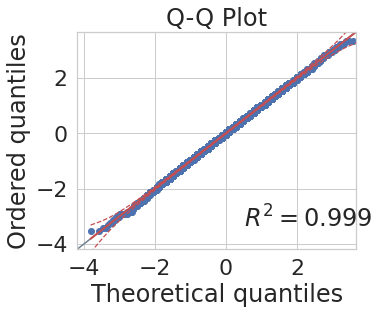

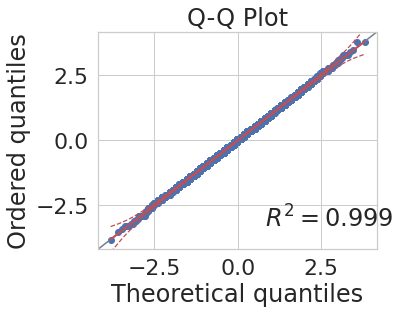

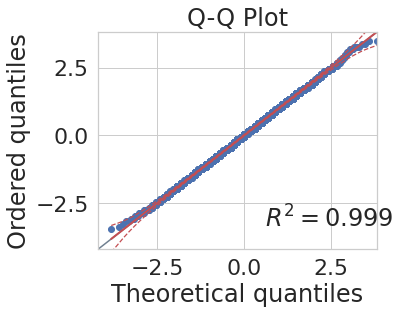

In [46]:
#Также мосмотрим на  нормальность через квантиль-квантиль графики
pg.qqplot(A)
pg.qqplot(B)
pg.qqplot(C)

Если какие-то точки выходят на пределы доверительного интервала, мы можем с определенной степенью уверенности сказать, что на самом деле наше распределение вообщем-то не нормальное, в нашем случае оно нормальное.


Для сравнения средних я использую 
однофакторный дисперсионный анализ 
. Значение статистики равно 2886
, а р-уровень значимости составил 
0


In [47]:
ss.f_oneway(A, B, C)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

Определим, между какими группами есть статистически значимые различия.

In [48]:
pairwise_tukeyhsd(task_1.events, task_1.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


Между всеми группами есть значимые различия

reject = True - различия значимые

По итогу будем использовать картинки B-квадратные (meandiff)

Проверим, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

In [49]:
task_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


id – id клиента в эксперименте

segment – сегмент (high/low)

group – вид кнопки (control – старая версия, test – новая версия)

events – сколько блюд суммарно было заказано за период

Посмотрим, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

In [50]:
formula = 'events ~ group + segment + group:segment'
model = ols(formula, task_2).fit()
aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group:segment,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


Визуализируем распределение events для контрольной и тестовой групп.

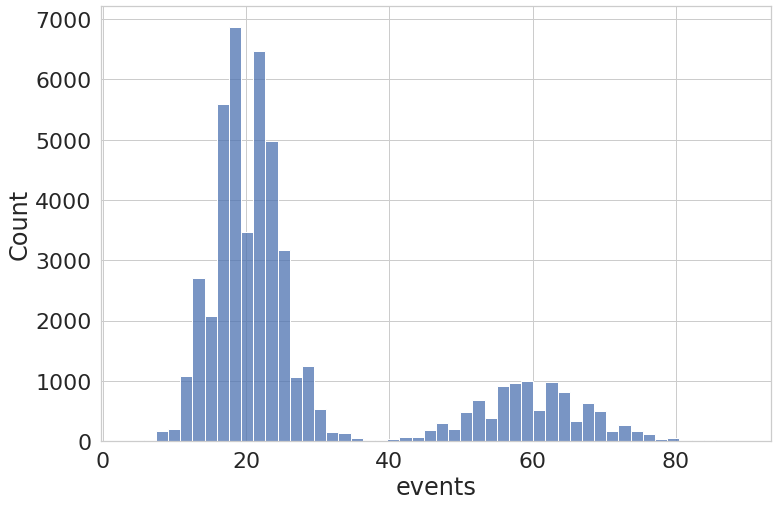

In [52]:
sns.histplot(data=task_2.query('group == "control"'), x="events", bins=50)

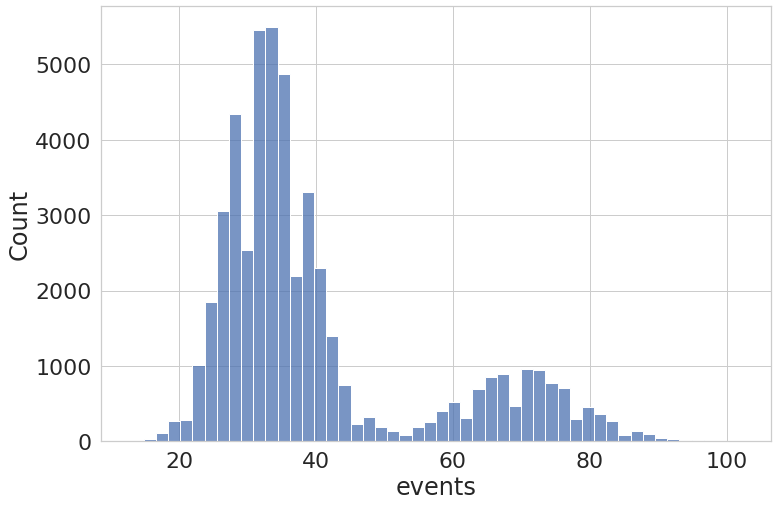

In [53]:
sns.histplot(data=task_2.query('group == "test"'), x="events", bins=50)

Посчитаем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

In [57]:
task_2.groupby(['group', 'segment']).events.describe().round(2)

count   mean   std   min   25%   50%   75%    max
group   segment                                                     
control high     10000.0  59.97  7.81  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.03  4.47   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.94  8.40  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.03  5.72  13.0  29.0  33.0  37.0   59.0

Проведем тест

In [60]:
task_2['combination'] = task_2['group'] + ' \ ' + task_2['segment']

In [62]:
task_2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test \ high
1,96723,test,high,71.0,test \ high
2,68719,test,high,80.0,test \ high
3,50399,test,high,80.0,test \ high
4,95613,test,high,78.0,test \ high


In [68]:
pairwise_tukeyhsd(task_2.events, task_2.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control \ high,control \ low,-39.9392,0.001,-40.1073,-39.7711,True
control \ high,test \ high,9.9677,0.001,9.7551,10.1803,True
control \ high,test \ low,-26.9449,0.001,-27.113,-26.7768,True
control \ low,test \ high,49.9069,0.001,49.7388,50.075,True
control \ low,test \ low,12.9944,0.001,12.888,13.1007,True
test \ high,test \ low,-36.9126,0.001,-37.0807,-36.7445,True


Визуализируем результаты теста

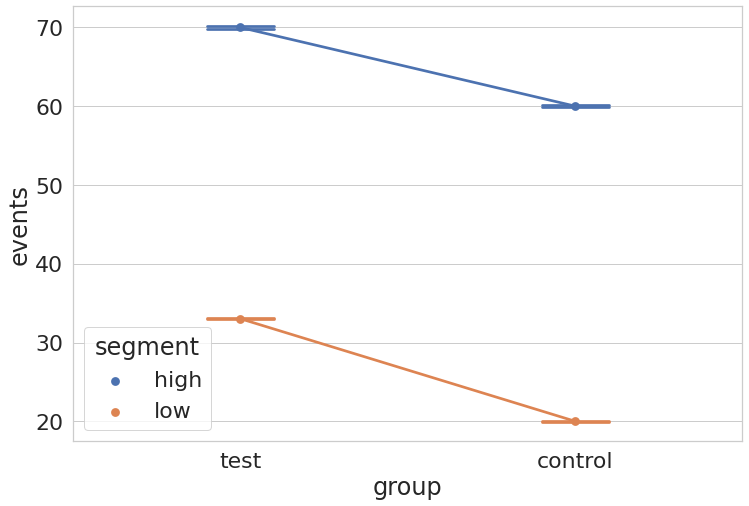

In [70]:
sns.pointplot(x="group", y="events", hue="segment", data=task_2, capsize=0.2)

Фактор group оказался 
значимым

фактор segment – 
значимым

их взаимодействие – 
значимо

Судя по графику, для всех групп среднее значение events 
увеличилось
, поэтому решение: 
Выкатываем новую версию
.